Dataset para con diagnosticos


Columnas disponibles:
['User_ID', 'Age', 'Gender', 'Occupation', 'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours', 'Social_Media_Usage', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage']

Distribución de Mental_Health_Condition:
Mental_Health_Condition
No     25003
Yes    24997
Name: count, dtype: int64


C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:47:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


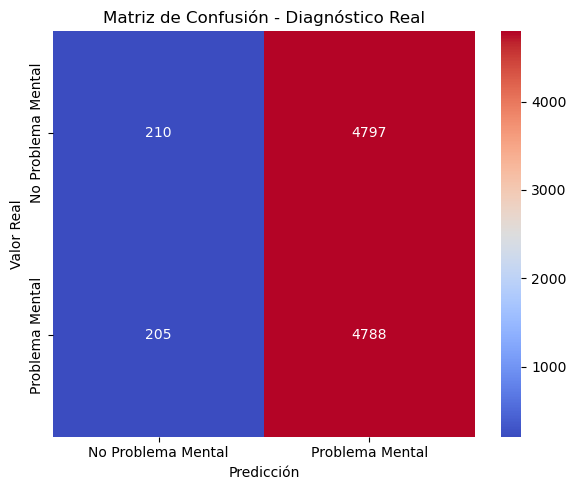


Reporte de Clasificación - Diagnóstico Real:
                    precision    recall  f1-score   support

No Problema Mental       0.51      0.04      0.08      5007
   Problema Mental       0.50      0.96      0.66      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.37     10000
      weighted avg       0.50      0.50      0.37     10000



In [1]:
# --- 1. Cargar el dataset ---
import pandas as pd
import shap

df_diagnostico = pd.read_csv('mental_health_data final data.csv')

print("\nColumnas disponibles:")
print(df_diagnostico.columns.tolist())

print("\nDistribución de Mental_Health_Condition:")
print(df_diagnostico['Mental_Health_Condition'].value_counts())

features_diagnostico = [
    'Age', 'Gender', 'Occupation', 'Country', 'Severity', 'Consultation_History',
    'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours',
    'Social_Media_Usage', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage'
]

df_model_diagnostico = df_diagnostico[features_diagnostico + ['Mental_Health_Condition']].copy()

mental_health_mapping = {'Yes': 1, 'No': 0}
df_model_diagnostico = df_model_diagnostico[df_model_diagnostico['Mental_Health_Condition'].isin(['Yes', 'No'])]
df_model_diagnostico['target'] = df_model_diagnostico['Mental_Health_Condition'].map(mental_health_mapping)
df_model_diagnostico = df_model_diagnostico.drop(columns=['Mental_Health_Condition'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['Gender', 'Occupation', 'Country', 'Severity', 'Consultation_History',
            'Stress_Level', 'Diet_Quality', 'Smoking_Habit', 'Alcohol_Consumption', 'Medication_Usage']:
    df_model_diagnostico[col] = le.fit_transform(df_model_diagnostico[col])

from sklearn.model_selection import train_test_split
X_diag = df_model_diagnostico.drop(columns='target')
y_diag = df_model_diagnostico['target']

X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X_diag, y_diag, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced_diag, y_train_balanced_diag = smote.fit_resample(X_train_diag, y_train_diag)

from xgboost import XGBClassifier

xgb_diag = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=300,
    scale_pos_weight=len(y_train_balanced_diag[y_train_balanced_diag == 0]) / len(y_train_balanced_diag[y_train_balanced_diag == 1])
)

xgb_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_probs_diag = xgb_diag.predict_proba(X_test_diag)[:, 1]
threshold = 0.4
y_pred_diag = (y_probs_diag >= threshold).astype(int)

cm_diag = confusion_matrix(y_test_diag, y_pred_diag)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_diag, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['No Problema Mental', 'Problema Mental'],
            yticklabels=['No Problema Mental', 'Problema Mental'])
plt.title('Matriz de Confusión - Diagnóstico Real')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación - Diagnóstico Real:")
print(classification_report(y_test_diag, y_pred_diag, target_names=['No Problema Mental', 'Problema Mental']))


In [3]:
# --- Random Forest ---
from sklearn.ensemble import RandomForestClassifier

rf_diag = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=None
)

rf_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

y_pred_rf = rf_diag.predict(X_test_diag)

print("\nReporte de Clasificación - Random Forest (Diagnóstico Real):")
print(classification_report(y_test_diag, y_pred_rf, target_names=['No Problema Mental', 'Problema Mental']))

from sklearn.linear_model import LogisticRegression

lr_diag = LogisticRegression(
    random_state=42,
    max_iter=1000
)

lr_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

y_pred_lr = lr_diag.predict(X_test_diag)

print("\nReporte de Clasificación - Logistic Regression (Diagnóstico Real):")
print(classification_report(y_test_diag, y_pred_lr, target_names=['No Problema Mental', 'Problema Mental']))

from xgboost import XGBClassifier

xgb_diag = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=300,
    scale_pos_weight=len(y_train_balanced_diag[y_train_balanced_diag == 0]) / len(y_train_balanced_diag[y_train_balanced_diag == 1])
)

xgb_diag.fit(X_train_balanced_diag, y_train_balanced_diag)

y_probs_diag = xgb_diag.predict_proba(X_test_diag)[:, 1]
threshold = 0.4
y_pred_xgb = (y_probs_diag >= threshold).astype(int)

print("\nReporte de Clasificación - XGBoost Tuned (Diagnóstico Real):")
print(classification_report(y_test_diag, y_pred_xgb, target_names=['No Problema Mental', 'Problema Mental']))



Reporte de Clasificación - Random Forest (Diagnóstico Real):
                    precision    recall  f1-score   support

No Problema Mental       0.50      0.53      0.52      5007
   Problema Mental       0.50      0.47      0.49      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.50     10000
      weighted avg       0.50      0.50      0.50     10000


Reporte de Clasificación - Logistic Regression (Diagnóstico Real):
                    precision    recall  f1-score   support

No Problema Mental       0.50      0.50      0.50      5007
   Problema Mental       0.50      0.50      0.50      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.50     10000
      weighted avg       0.50      0.50      0.50     10000



C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:48:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Reporte de Clasificación - XGBoost Tuned (Diagnóstico Real):
                    precision    recall  f1-score   support

No Problema Mental       0.51      0.04      0.08      5007
   Problema Mental       0.50      0.96      0.66      4993

          accuracy                           0.50     10000
         macro avg       0.50      0.50      0.37     10000
      weighted avg       0.50      0.50      0.37     10000



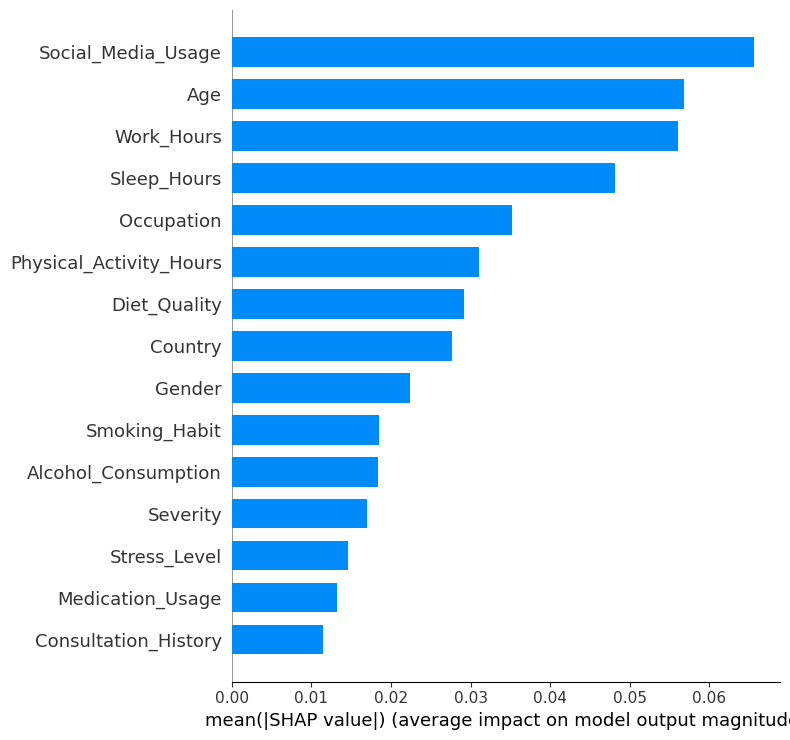


Predicción para muestra individual (Diagnóstico Real):
Age                        27.0
Gender                      0.0
Occupation                  1.0
Country                     0.0
Severity                    1.0
Consultation_History        1.0
Stress_Level                1.0
Sleep_Hours                 6.8
Work_Hours                 35.0
Physical_Activity_Hours     1.0
Social_Media_Usage          2.9
Diet_Quality                2.0
Smoking_Habit               2.0
Alcohol_Consumption         1.0
Medication_Usage            0.0
Name: 33553, dtype: float64


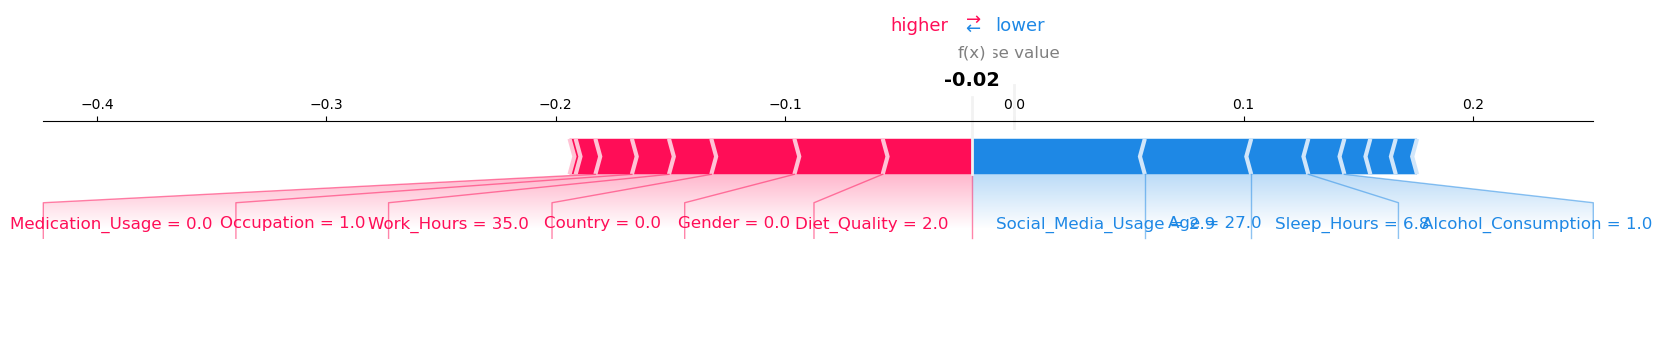

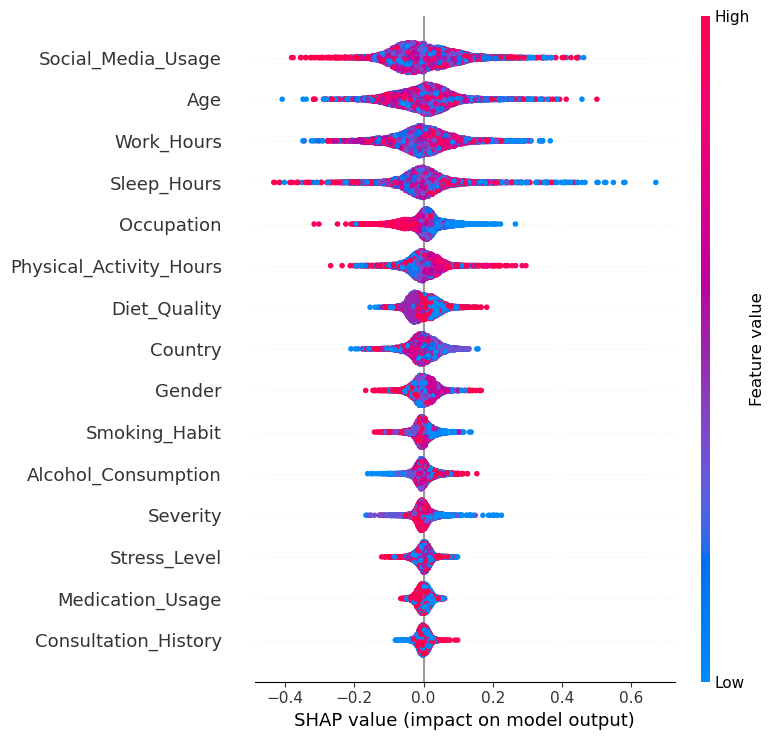

In [5]:
import shap
import matplotlib.pyplot as plt

explainer_diag = shap.TreeExplainer(xgb_diag)

shap_values_diag = explainer_diag.shap_values(X_test_diag)

plt.title('Importancia Global de Variables (SHAP) - Diagnóstico Real')
shap.summary_plot(shap_values_diag, X_test_diag, plot_type="bar")
plt.show()

sample_index = 0 

print("\nPredicción para muestra individual (Diagnóstico Real):")
print(X_test_diag.iloc[sample_index])

shap.force_plot(
    explainer_diag.expected_value,
    shap_values_diag[sample_index, :],
    X_test_diag.iloc[sample_index, :],
    matplotlib=True
)

shap.summary_plot(shap_values_diag, X_test_diag, plot_type="dot")


In [7]:
# --- 1. Importar librerías ---
import lime
import lime.lime_tabular
import numpy as np

explainer_lime_diag = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_balanced_diag),
    feature_names=X_train_balanced_diag.columns.tolist(),
    class_names=['No Problema Mental', 'Problema Mental'],
    mode='classification'
)

sample_index_diag = 0 
sample_diag = X_test_diag.iloc[sample_index_diag]

exp_diag = explainer_lime_diag.explain_instance(
    data_row=sample_diag,
    predict_fn=xgb_diag.predict_proba
)

exp_diag.show_in_notebook(show_table=True)

print(exp_diag.as_list())

C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\abiel\AppData\Roaming\Python\Python312\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

[('Occupation <= 1.00', 0.01606131564359641), ('Age <= 29.75', 0.010657943537161433), ('Physical_Activity_Hours <= 2.00', -0.007772996891289037), ('1.90 < Social_Media_Usage <= 3.20', -0.0057596975616118155), ('Country <= 1.00', 0.0055229618350513855), ('Work_Hours <= 42.00', 0.004849939632511421), ('1.00 < Smoking_Habit <= 2.00', -0.003969321942669454), ('0.00 < Consultation_History <= 1.00', 0.0032672067162751394), ('Medication_Usage <= 0.00', 0.0029375777257983136), ('1.00 < Diet_Quality <= 2.00', 0.0029362911686232895)]


Este dataset hay que trabajarlo mejor para generalizar, ya que manda un 50% casi al azar y eso claramente es un fallo en el modelo